In [1]:
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch_geometric.loader import DataLoader
from torch.optim import Adam

from grakel.utils import graph_from_networkx
from tqdm.notebook import tqdm

from utils import preprocess_dataset, construct_nx_from_adj

from models.generator import ConditionalGraphGenerator
from models.discriminator import ConditionalGraphDiscriminator

In [2]:
def load_graph(filepath):
    ext = os.path.splitext(filepath)[1]
    if ext == '.edgelist':
        return nx.read_edgelist(filepath)
    elif ext == '.graphml':
        return nx.read_graphml(filepath)
    else:
        raise ValueError(f"Unsupported graph format: {ext}")

def load_description(filepath):
    with open(filepath, 'r') as file:
        return file.read()

data_dir = '../data'

def load_sample(sample_id, dataset):
    for ext in ['.edgelist', '.graphml']:
        graph_path = os.path.join(data_dir, dataset, 'graph', f'graph_{sample_id}{ext}')
        if os.path.exists(graph_path):
            break
    else:
        raise FileNotFoundError(f"Graph file for sample {sample_id} not found in supported formats.")
        
    description_path = os.path.join(data_dir, dataset, 'description', f'graph_{sample_id}.txt')

    graph = load_graph(graph_path)
    description = load_description(description_path)

    return graph, description

def load_test_descriptions():
    test_file = os.path.join(data_dir, 'test', 'test.txt')
    test_descriptions = {}

    with open(test_file, 'r') as file:
        for line in file:
            if line.strip():
                graph_id, description = line.split(',', 1)
                test_descriptions[graph_id.strip()] = description.strip()

    return test_descriptions
test_description = load_test_descriptions()

In [3]:
sample_id = 0
graph, description = load_sample(sample_id, 'train')
print("Description: \n", description)
print("\nGraph:")
print(graph.nodes)
print(graph.edges)
# nx.draw(graph, with_labels=True)
# plt.show()

Description: 
 This graph comprises 10 nodes and 5 edges. The average degree is equal to 1 and there are 0 triangles in the graph. The global clustering coefficient and the graph's maximum k-core are 0 and 1 respectively. The graph consists of 5 communities.

Graph:
['0', '1', '5', '6', '3', '9', '7', '8', '2', '4']
[('0', '1'), ('5', '6'), ('3', '9'), ('7', '8'), ('2', '4')]


In [4]:
n_max_nodes = 50
spectral_emb_dim = 10
trainset = preprocess_dataset('train', n_max_nodes, spectral_emb_dim)
validset = preprocess_dataset('valid', n_max_nodes, spectral_emb_dim)
testset = preprocess_dataset('test', n_max_nodes, spectral_emb_dim)

/home/infres/abrik-22/ALTEGRAD_challenge/code/utils.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  description_embeddings = torch.load(f'../data/{dataset}_embeddings.p

Dataset ../data/dataset_train.pt loaded from file
Dataset ../data/dataset_valid.pt loaded from file
Dataset ../data/dataset_test.pt loaded from file


/home/infres/abrik-22/ALTEGRAD_challenge/code/utils.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_lst = torch.load(filename)


In [5]:
data0 = trainset[927]
x, edge_index, A, stats, desc_embd, filename = data0.x, data0.edge_index, data0.A, data0.stats, data0.description_embedding, data0.filename
print("x shape: ", x.shape)
print("edge_index shape: ", edge_index.shape)
print("A shape: ", A.shape)
print("stats: ", stats)
print("stats shape: ", stats.shape)
print("desc_embd shape: ", desc_embd.shape)
print("filename: ", filename)

x shape:  torch.Size([43, 16])
edge_index shape:  torch.Size([2, 84])
A shape:  torch.Size([1, 50, 50])
stats:  tensor([[43.0000, 42.0000,  1.9535,  0.0000,  0.0000,  1.0000,  7.0000]])
stats shape:  torch.Size([1, 7])
desc_embd shape:  torch.Size([1, 768])
filename:  graph_5772


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH = 10
EPOCHS = 100
stats_dim = 7
desc_embd_dim = 768
n_max_nodes = 50
noise_dim = 10

# initialize data loaders
train_loader = DataLoader(trainset, batch_size=BATCH, shuffle=True)
val_loader = DataLoader(validset, batch_size=BATCH, shuffle=False)
test_loader = DataLoader(testset, batch_size=BATCH, shuffle=False)

In [ ]:
# Generator and Discriminator initialization
generator = ConditionalGraphGenerator(noise_dim=noise_dim, embedding_dim=stats_dim, num_nodes=n_max_nodes).to(device)
discriminator = ConditionalGraphDiscriminator(num_nodes=n_max_nodes, embedding_dim=stats_dim).to(device)

optimizer_g = Adam(generator.parameters(), lr=0.0001)
optimizer_d = Adam(discriminator.parameters(), lr=0.0001)


# Training 
def train(G, D, train_loader, val_loader, optimizer_g, optimizer_d, device, num_epochs):
    G.train()
    D.train()
    
    gen_losses = []
    disc_losses = []
    val_gen_losses = []
    val_disc_losses = []
    
    for epoch in range(num_epochs):
        # Initialize epoch losses
        gen_loss_epoch = 0.0
        disc_loss_epoch = 0.0

        # Training loop
        print(f"\nEpoch [{epoch + 1}/{num_epochs}]")
        train_bar = tqdm(train_loader, desc="Training", leave=True)
        for batch in train_bar:
            # Move data to the device
            batch_adj = batch.A.to(device)  # Real adjacency matrices
            batch_stats = batch.stats.to(device)  # Graph statistics
            # batch_embeddings = batch.description_embedding.to(device) # Graph description embeddings
            
            # Train Discriminator
            noise = torch.randn(batch_stats.size(0), noise_dim).to(device)
            generated_adj = G(noise, batch_stats)
            
            real_score = D(batch_adj, batch_stats)
            fake_score = D(generated_adj, batch_stats)
            
            disc_loss = -torch.mean(real_score) + torch.mean(fake_score)
            
            optimizer_d.zero_grad()
            disc_loss.backward()
            optimizer_d.step()
            
            # Gradient clipping for the discriminator
            for p in D.parameters():
                p.data.clamp_(-0.01, 0.01)
            
            # Train Generator
            noise = torch.randn(batch_stats.size(0), noise_dim).to(device)
            generated_adj = G(noise, batch_stats)
            fake_score = D(generated_adj, batch_stats)
            
            gen_loss = -torch.mean(fake_score)
            
            optimizer_g.zero_grad()
            gen_loss.backward()
            optimizer_g.step()
            
            # Accumulate losses
            gen_loss_epoch += gen_loss.item()
            disc_loss_epoch += disc_loss.item()
            
            # Update tqdm description
            train_bar.set_postfix(
                Generator_Loss=f"{gen_loss.item():.4f}",
                Discriminator_Loss=f"{disc_loss.item():.4f}"
            )
        
        # Append epoch losses
        gen_losses.append(gen_loss_epoch / len(train_loader))
        disc_losses.append(disc_loss_epoch / len(train_loader))
        
        # Validation loop
        G.eval()
        D.eval()
        val_gen_loss = 0.0
        val_disc_loss = 0.0
        val_bar = tqdm(val_loader, desc="Validating", leave=True)
        with torch.no_grad():
            for val_batch in val_bar:
                val_adj = val_batch.A.to(device)
                val_stats = val_batch.stats.to(device)
                # val_embeddings = val_batch.description_embedding.to(device)
                
                val_noise = torch.randn(val_stats.size(0), noise_dim).to(device)
                val_generated_adj = G(val_noise, val_stats)
                
                val_real_score = D(val_adj, val_stats)
                val_fake_score = D(val_generated_adj, val_stats)
                
                val_disc_loss += -torch.mean(val_real_score) + torch.mean(val_fake_score)
                val_gen_loss += -torch.mean(val_fake_score)
                
                # Update tqdm description
                val_bar.set_postfix(
                    Validation_Generator_Loss=f"{val_gen_loss:.4f}",
                    Validation_Discriminator_Loss=f"{val_disc_loss:.4f}"
                )
        
        # Average the validation losses
        val_gen_loss /= len(val_loader)
        val_disc_loss /= len(val_loader)
        
        # Append validation losses
        val_gen_losses.append(val_gen_loss.item())
        val_disc_losses.append(val_disc_loss.item())
    
    return gen_losses, disc_losses, val_gen_losses, val_disc_losses


# Assuming generator, discriminator, optimizers, and loaders are defined:
gen_losses, disc_losses, val_gen_losses, val_disc_losses = train(
    G=generator, 
    D=discriminator, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    optimizer_g=optimizer_g, 
    optimizer_d=optimizer_d, 
    device=device, 
    num_epochs=EPOCHS
)


Epoch [1/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [2/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [3/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [4/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [5/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [6/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [7/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [8/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [9/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [10/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [11/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [12/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [13/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [14/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [15/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [16/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [17/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [18/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [19/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [20/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [21/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [22/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [23/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [24/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [25/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [26/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [27/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [28/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [29/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [30/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [31/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [32/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [33/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [34/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [35/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [36/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [37/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [38/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [39/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [40/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [41/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [42/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [43/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [44/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [45/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [46/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [47/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [48/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [49/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [50/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [51/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [52/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [53/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [54/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [55/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [56/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [57/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [58/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [59/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [60/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [61/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [62/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [63/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [64/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [65/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [66/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [67/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [68/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [69/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [70/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [71/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [72/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [73/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [74/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [75/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [76/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [77/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [78/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [79/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [80/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [81/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [82/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [83/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [84/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [85/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [86/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [87/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [88/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [89/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [90/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [91/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [92/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [93/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [94/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [95/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [96/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [97/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [98/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [99/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch [100/100]


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]

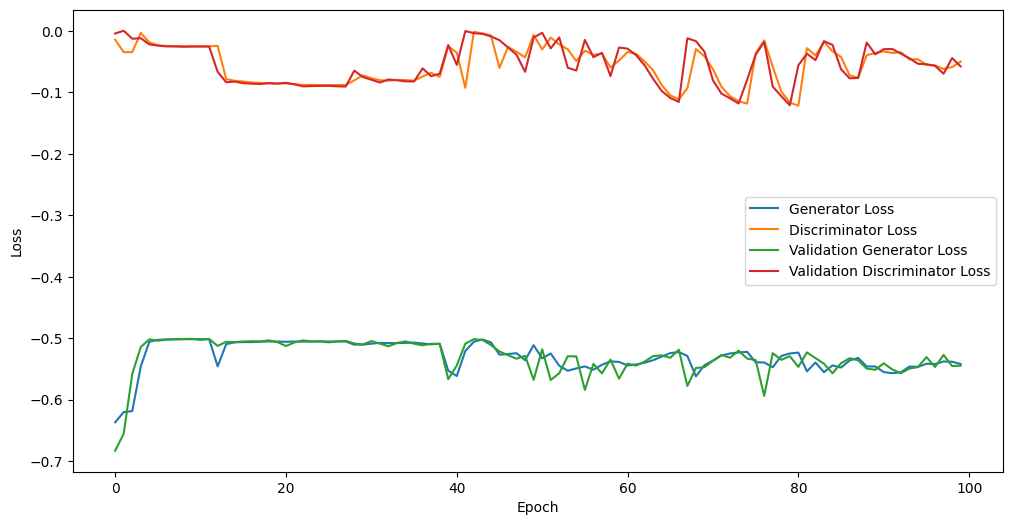

In [9]:
# Plot losses
plt.figure(figsize=(12, 6))
plt.plot(gen_losses, label="Generator Loss")
plt.plot(disc_losses, label="Discriminator Loss")
plt.plot(val_gen_losses, label="Validation Generator Loss")
plt.plot(val_disc_losses, label="Validation Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [10]:
import csv

def test_model_to_csv(generator, test_loader, output_csv):
    """
    Test the generator model and save generated graph edges to a CSV file.

    Args:
        generator (nn.Module): Trained generator model.
        test_loader (DataLoader): DataLoader for the test dataset.
        output_csv (str): Path to save the CSV file containing graph IDs and edges.

    Returns:
        None
    """
    generator.eval()  # Set generator to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)

    # test_adj_matrices = []
    test_graphs = []
    
    print("Starting testing and saving to CSV...")
    with open(output_csv, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        # Write the header
        writer.writerow(["graph_id", "edge_list"])

        with torch.no_grad():  # Disable gradient computation for inference
            for data in tqdm(test_loader, desc="Processing test set"):
                # Move data to device
                data = data.to(device)
                
                # Extract stats and filenames
                stats = data.stats
                # description_embedding = data.description_embedding
                graph_ids = data.filename

                # Generate random noise for the generator
                batch_size = stats.size(0)
                noise_dim = generator.noise_dim  # Assuming the generator has an attribute for noise dimension
                noise = torch.randn(batch_size, noise_dim).to(device)
          
                # Generate graphs (adjacency matrices) conditioned on description_embedding
                generated_adjs = generator(noise, stats)

                # Process each generated graph
                for i in range(batch_size):
                    # Convert adjacency matrix to a NetworkX graph
                    adj_matrix = generated_adjs[i].detach().cpu().numpy()
                    adj_matrix = np.round(adj_matrix)  # Round to 0 or 1
                    # adj_matrix = np.where(adj_matrix > 0.5, 1, 0)  # Threshold to 0 or 1
                    adj_matrix = adj_matrix * (1 - np.eye(adj_matrix.shape[0]))  # Remove self-loops
                    # test_adj_matrices.append(adj_matrix)
                    graph = construct_nx_from_adj(adj_matrix.astype(int))  
                    test_graphs.append(graph)
                    
                    # Convert edges to a list of tuples
                    edge_list = list(graph.edges())

                    # Format edge list as a string
                    edge_list_text = ", ".join([f"({u}, {v})" for u, v in edge_list])

                    # Write the graph ID and edge list to the CSV
                    writer.writerow([graph_ids[i], edge_list_text])

    print(f"Testing complete. Results saved in {output_csv}.")
    return test_graphs
    
output_csv = "../GAN_condtion_disc2.csv"
test_graphs = test_model_to_csv(generator, test_loader, output_csv)

Starting testing and saving to CSV...


Processing test set:   0%|          | 0/100 [00:00<?, ?it/s]

Testing complete. Results saved in ../GAN_condtion_disc2.csv.


In [11]:
import ast
import pandas as pd

# Load the CSV file into a DataFrame
file_path = '../GAN_condtion.csv'  # Replace with your file's path
df = pd.read_csv(file_path)

# Function to parse the edge list string into a list of tuples
def parse_edge_list(edge_list_str):
    return ast.literal_eval(f"[{edge_list_str}]")

# Iterate through the DataFrame rows and create graphs
graphs = {}
for _, row in df.iterrows():
    graph_id = row['graph_id']
    edge_list_str = row['edge_list']
    edge_list = parse_edge_list(edge_list_str)
    
    # Create a NetworkX graph from the edge list
    G = nx.Graph()
    G.add_edges_from(edge_list)
    graphs[graph_id] = G
    
# Print the first 20 graphs ID and number of nodes and edges and description
for graph_id, graph in list(graphs.items())[:100]:
    print(f"Graph ID: {graph_id}, Number of nodes: {graph.number_of_nodes()}, Number of edges: {graph.number_of_edges()}")
    print(f"Description: {test_description[graph_id]}")
    print()

Graph ID: graph_0, Number of nodes: 50, Number of edges: 362
Description: This graph comprises 50 nodes and 589 edges. The average degree is equal to 23.56 and there are 3702 triangles in the graph. The global clustering coefficient and the graph's maximum k-core are 0.6226034308779012 and 18 respectively. The graph consists of 3 communities.

Graph ID: graph_1, Number of nodes: 47, Number of edges: 105
Description: This graph comprises 20 nodes and 19 edges. The average degree is equal to 1.9 and there are 0 triangles in the graph. The global clustering coefficient and the graph's maximum k-core are 0 and 1 respectively. The graph consists of 4 communities.

Graph ID: graph_2, Number of nodes: 50, Number of edges: 142
Description: This graph comprises 28 nodes and 165 edges. The average degree is equal to 11.785714285714286 and there are 387 triangles in the graph. The global clustering coefficient and the graph's maximum k-core are 0.4742647058823529 and 8 respectively. The graph con